# 1. Setup

In [10]:
import pickle
from time import time

from lightgbm import LGBMRegressor, plot_tree
from matplotlib.patches import Patch
import plotly.express as px
from pqdm.processes import pqdm
from scipy.optimize import curve_fit
from scipy.stats import entropy
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sklearn as skl
from xgboost import to_graphviz, XGBRegressor

from utils import *

# 2. Prepare data

## 2.1. Trips

In [2]:
trips = pd.read_parquet('../data/trips2.parquet').disp()

477,550 rows x 8 cols; Memory: 13.2 MiB


Distance       Time      Speed        Mode     Purpose    LongStay  \
   <float64>  <float64>  <float64>  <category>  <category>  <category>   
0   8.439379  16.182075  31.291583       Drive       Other          No   

      ODUrban         SES  
   <category>  <category>  
0       S → S         Mid

In [3]:
factors = list(trips.select_dtypes(CAT).columns); factors

['Mode', 'Purpose', 'LongStay', 'ODUrban', 'SES']

## 2.2. Factor combinations

In [4]:
def get_combs(trips=trips):
    factors = list(trips.select_dtypes(CAT).columns)
    df = list(it.product(*[['Overall'] + list(
        trips[col].cat.categories) for col in factors]))
    df = Pdf(df, columns=factors).rename_axis('Comb')
    for col in df.columns:
        cats = ['Overall'] + list(trips[col].cat.categories)
        df[col] = pd.Categorical(df[col], cats)
    return df

combs = get_combs().disp()

1,440 rows x 5 cols; Memory: 0.0 MiB


Mode     Purpose    LongStay     ODUrban         SES
Comb  <category>  <category>  <category>  <category>  <category>
0        Overall     Overall     Overall     Overall     Overall

In [5]:
def get_levels(combs=combs):
    res = []
    for col in combs.columns:
        df = combs[combs[col] != 'Overall']
        idx = df[(df.drop(columns=col) == 'Overall').all(1)].index
        df = combs.loc[idx, col].rename('Level').reset_index()
        res.append(df.assign(Factor=col))
    res = pd.concat(res).reset_index(drop=1)
    return res

levels = get_levels().disp()

17 rows x 3 cols; Memory: 0.0 MiB


Comb     Level    Factor
   <int64>  <object>  <object>
0      288     Drive      Mode

## Compute β parameters

In [6]:
def get_comb_hist(trips=trips, **comb):
    res = []
    comb_id = comb.pop('Comb', np.nan)
    min_samples = comb.pop('min_samples', np.inf)
    query = ' & '.join([f'{k}=="{v}"' for k, v in
                        comb.items() if v != 'Overall'])
    df = trips.query(query) if query else trips
    if len(df) <= min_samples:
        return res
    for target, vmax in D(Distance=100, Time=90).items():
        y = df[target].pipe(lambda x: x[x <= vmax])
        y, x = np.histogram(y, bins=np.arange(0, vmax + 0.1))
        y = (1 - (y / y.sum()).cumsum()).clip(0)
        beta = -curve_fit(lambda x, b: np.exp(b * x), x[1:], y)[0][0]
        res.append(D(Comb=comb_id, Target=target) | comb | D(Beta=beta))
    return res

# x = get_comb_hist(**D(Mode='Drive', Purpose='Work', LongStay='No',
#                       ODUrban='U → U', SES='High', min_samples=100)); x

In [7]:
def get_comb_params(n_min=100, njobs=20, combs=combs):
    kwargs = [v | D(Comb=k, min_samples=n_min)
              for k, v in combs.T.to_dict().items()]
    df = Pdf(sum(pqdm(kwargs, get_comb_hist, n_jobs=njobs,
                      argument_type='kwargs'), []))
    df['Area'] = 1 / df.Beta
    return df[['Comb', 'Target', 'Beta', 'Area']]

betas = get_comb_params().disp() # t=0:03
# x = get_comb_params(); x

QUEUEING TASKS | :   0%|          | 0/1440 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1440 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1440 [00:00<?, ?it/s]

1,818 rows x 4 cols; Memory: 0.2 MiB


Comb    Target       Beta       Area
   <int64>  <object>  <float64>  <float64>
0        0  Distance   0.099273  10.073197

# 3. Modeling for SHAP

## 3.1. Test models

In [8]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVR
import xgboost as xgb

In [11]:
models = (
    ## Linear models
    ('Linear Regression', LinearRegression(), D(
        fit_intercept=[True, False],
    )),
    ('Bayesian Ridge',
     BayesianRidge(max_iter=1000),
     D(alpha_1=[.5e-6, 1e-6, 2e-6],
       alpha_2=[.5e-6, 1e-6, 2e-6],
       lambda_1=[.5e-6, 1e-6, 2e-6],
       lambda_2=[.5e-6, 1e-6, 2e-6],
    )),
    ('SGD Regression', SGDRegressor(max_iter=1000), D(
        alpha=[1e-05, 0.0001, 0.001, 0.01],
        l1_ratio=[0.1, 0.15, 0.2, 0.3],
        penalty=['l2', 'elasticnet'],
    )),
    ## Kernel models
    ('Linear SVR', LinearSVR(dual='auto', max_iter=50_000), D(
        C=[0.5, 0.75, 1.0, 1.25, 1.5],
        epsilon=[0, 0.1, 0.2],
        loss=['epsilon_insensitive', 'squared_epsilon_insensitive']
    )),
    ## Decision tree models
    ('Random Forest',
     RandomForestRegressor(n_jobs=6, random_state=SEED),
     D(n_estimators=[100, 200, 300], max_depth=[10, 20, 30, 40],
    )),
    ('Light Gradient Boost',
     LGBMRegressor(n_jobs=6, force_row_wise=True, verbosity=-1,
                   random_state=SEED, num_leaves=1000),
     D(learning_rate=[0.05, 0.1, 0.5], max_depth=[10, 20, 30, 40],
       n_estimators=[100, 200, 500, 750],
    )),
    ('Extreme Gradient Boost',
     XGBRegressor(n_jobs=6, verbosity=0, random_state=SEED),
     D(booster=['gbtree', 'gblinear'], learning_rate=[0.05, 0.1, 0.5],
       n_estimators=[100, 200, 500, 750],
    )),
)

## 3.2. Select best estimators using CV

In [12]:
metrics = D(r2=r2_score, mae=mean_absolute_error, mape=mean_absolute_percentage_error, mse=mean_squared_error)

In [13]:
def cross_validate(combs=combs, betas=betas, models=models, metrics=metrics,
                   test_ratio=0.3, njobs=1, overwrite=False):
    outpath = Path('../data/comb_models.pickle')
    if outpath.exists() and not overwrite:
        return pd.read_pickle(outpath)
    res = []
    pbar = tqdm(list(it.product(models, ['Distance', 'Time'])))
    for (name, model, params), target in pbar:
        pbar.set_description(f'{name} for {target}')
        t = time()
        df = betas.query(f'Target=="{target}"')
        X = pd.get_dummies(combs.loc[df.Comb])
        Xtrain, Xtest, ytrain, ytest = train_test_split(
            X, df['Area'], test_size=test_ratio, random_state=SEED)
        cv = GridSearchCV(model, params, cv=5, n_jobs=njobs, scoring='r2')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            cv.fit(Xtrain, ytrain)
        row = D(target=target, family=name, model=cv.best_estimator_,
                params=cv.best_params_)
        ypred = cv.best_estimator_.predict(Xtest)
        for metric, func in metrics.items():
            row[metric] = func(ytest, ypred)
        res.append(row | D(runtime=time() - t))
    res = Pdf(res)
    res.to_pickle(mkfile(outpath))
    return res

cv_df = cross_validate(njobs=12, overwrite=1).disp() # t=0:31
# x = cross_validate(njobs=12); x

  0%|          | 0/14 [00:00<?, ?it/s]

14 rows x 9 cols; Memory: 0.0 MiB


target             family               model                   params  \
   <object>           <object>            <object>                 <object>   
0  Distance  Linear Regression  LinearRegression()  {'fit_intercept': True}   

          r2        mae       mape        mse    runtime  
   <float64>  <float64>  <float64>  <float64>  <float64>  
0   0.833698   2.351438   0.683796   9.719092   1.725497

In [14]:
(cv_df.assign(family=ordered_factor(cv_df.family))
 .drop(columns=['model', 'params', 'runtime'])
 .melt(['target', 'family'], var_name='metric')
 .assign(metric=lambda x: x.metric.str.upper())
 .rename(columns=str.title)
 .pivot_table('Value', 'Family', ['Target', 'Metric'])
 .reset_index())

Target                  Family  Distance                                \
Metric                               MAE      MAPE       MSE        R2   
0            Linear Regression  2.351438  0.683796  9.719092  0.833698   
1               Bayesian Ridge  2.332753  0.677577  9.742693  0.833295   
2               SGD Regression  2.353186  0.679476  9.782571  0.832612   
3                   Linear SVR  2.333449  0.676462  9.741383  0.833317   
4                Random Forest  0.598633  0.059219  1.389440  0.976226   
5         Light Gradient Boost  0.566459  0.114317  0.881138  0.984923   
6       Extreme Gradient Boost  0.395812  0.069767  0.695329  0.988102   

Target      Time                                 
Metric       MAE      MAPE        MSE        R2  
0       3.078816  0.142166  18.430867  0.846591  
1       3.084526  0.142325  18.463711  0.846318  
2       3.084715  0.142169  18.438561  0.846527  
3       3.080488  0.142141  18.422253  0.846663  
4       0.819884  0.032622   2.065720  0.982806  
5       0.712821  0.028657   1.627268  0.986456  
6       0.522864  0.020271   1.202656  0.989990

# 4. SHAP analysis

## 4.1. Compute values

In [15]:
def get_shap(betas=betas, combs=combs, cv=cv_df,
             model='Extreme Gradient Boost'):
    res = []
    models = cv.query(f'family=="{model}"')
    for target, df in betas.groupby('Target'):
        X = pd.get_dummies(combs.loc[df.Comb])
        model = models.query(f'target=="{target}"').iloc[0].model
        explainer = shap.TreeExplainer(model, seed=SEED)
        shaps = explainer(X).values
        d = Pdf(shaps, columns=X.columns, index=X.index)
        d.insert(0, 'Target', target)
        res.append(d)
    res = pd.concat(res).astype(D(Target=CAT))
    return res

shaps = get_shap().disp() # t=0:05
# x = get_shap(); x

[09:40:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:40:10] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


1,818 rows x 23 cols; Memory: 0.2 MiB


Target Mode_Overall Mode_Drive Mode_Transit  Mode_Walk  Mode_Bike  \
Comb  <category>    <float32>  <float32>    <float32>  <float32>  <float32>   
0       Distance     0.022605  -0.288852      -0.8383   1.877614   0.957727   

     Purpose_Overall Purpose_Work Purpose_Shopping Purpose_Other  ...  \
Comb       <float32>    <float32>        <float32>     <float32>  ...   
0           0.332747    -1.244887         0.412321      0.225644  ...   

     ODUrban_Overall ODUrban_U → U ODUrban_S → S ODUrban_R → R ODUrban_U ↔ S  \
Comb       <float32>     <float32>     <float32>     <float32>     <float32>   
0           0.058878      0.780381      0.228393     -0.093428     -0.394519   

     ODUrban_S ↔ R SES_Overall    SES_Low    SES_Mid   SES_High  
Comb     <float32>   <float32>  <float32>  <float32>  <float32>  
0        -1.027071    0.594759   0.281623   0.108533  -0.514495  

[2 rows x 23 columns]

In [21]:
XDist, XTime = [pd.get_dummies(combs.loc[betas.query(f'Target=="{trg}"').Comb]) for trg in ['Distance', 'Time']]
mDist, mTime = cv_df.query('family=="Extreme Gradient Boost"').model.tolist()
expDist, expTime = [shap.TreeExplainer(model, seed=SEED)(X) for model, X in zip([mDist, mTime], [XDist, XTime])]

[09:42:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[09:42:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


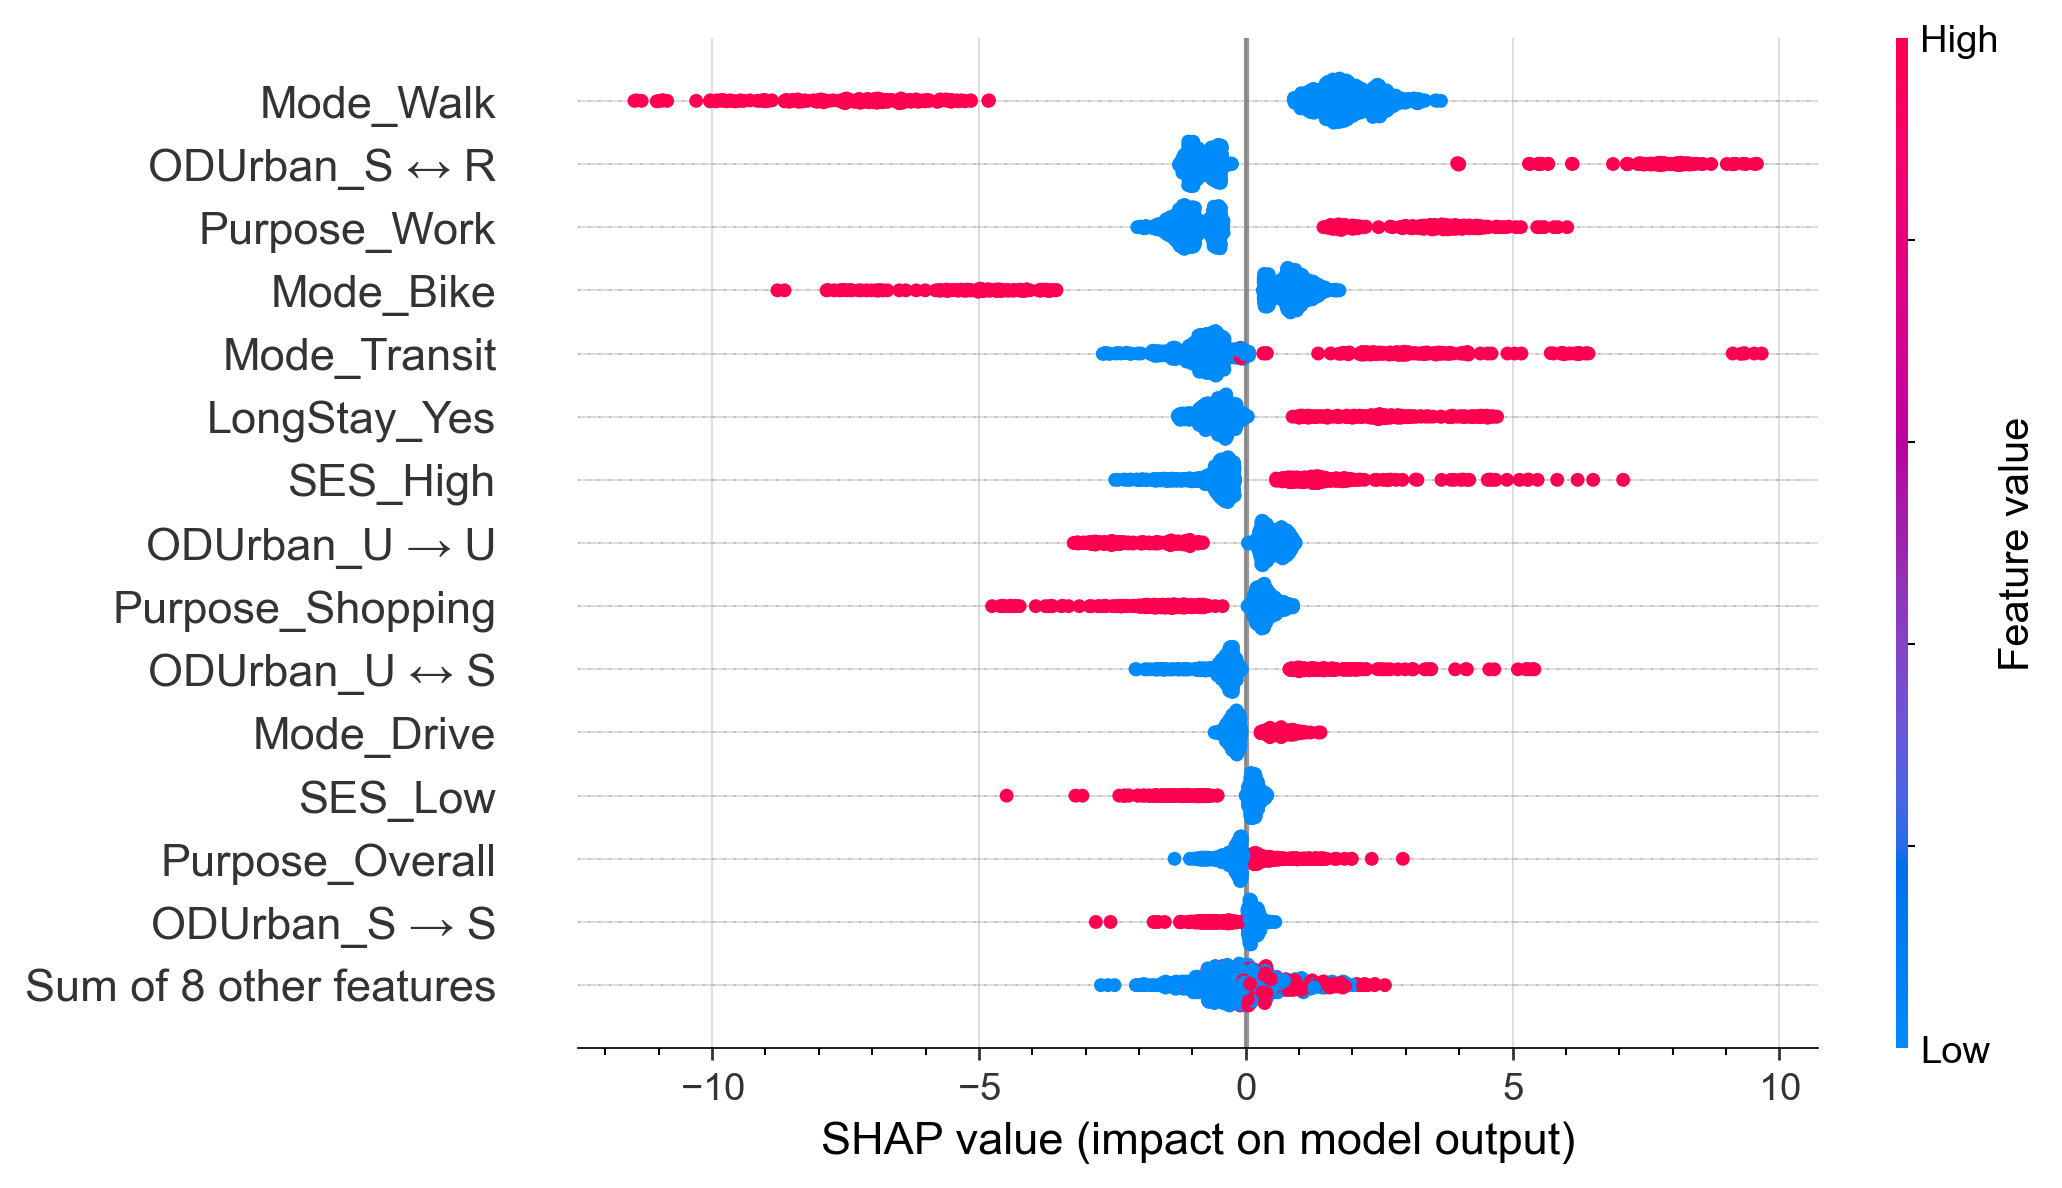

In [36]:
plt.figure(dpi=250)
shap.plots.beeswarm(expDist, 15, plot_size=0.25)

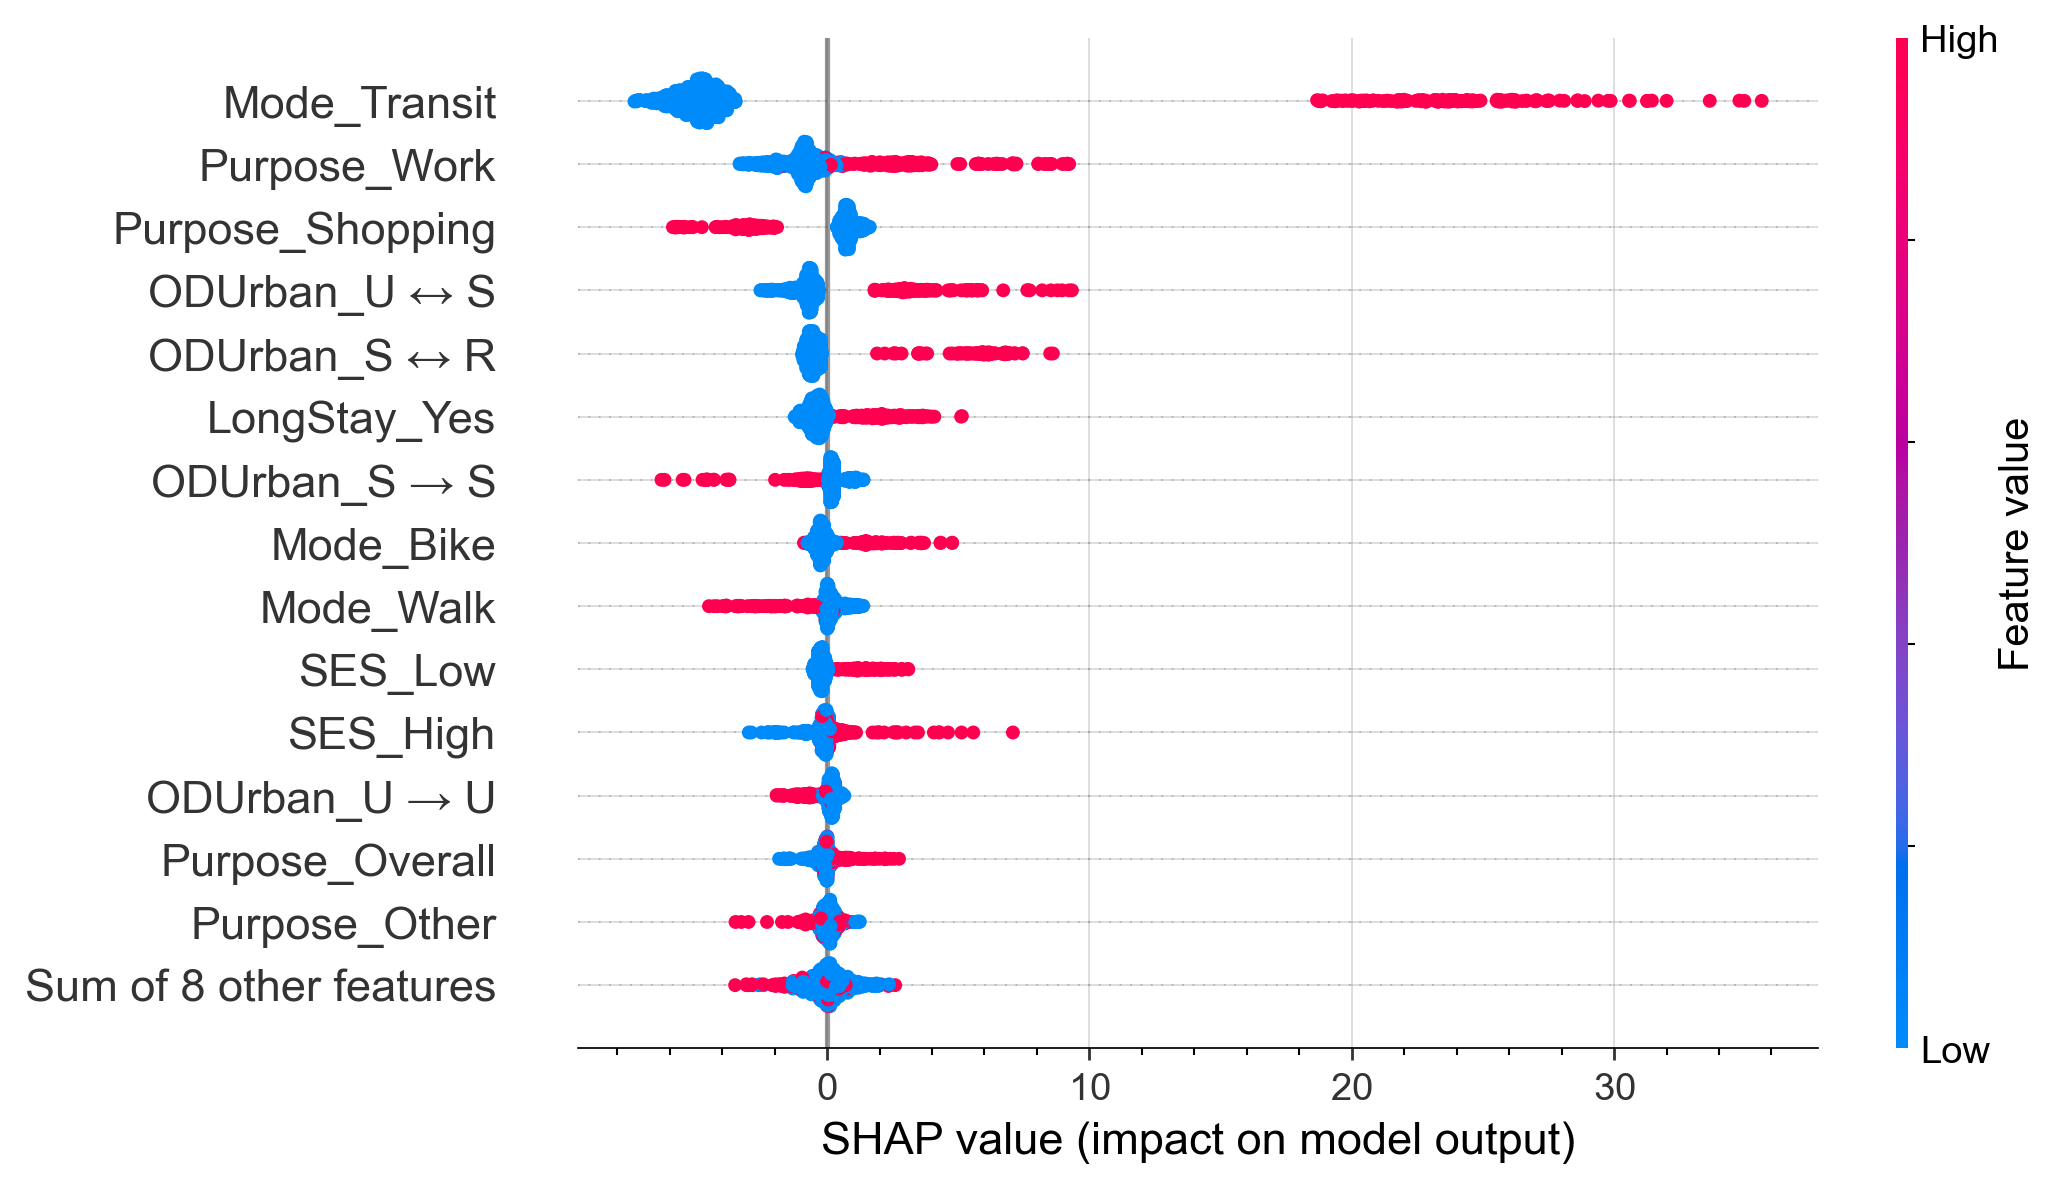

In [37]:
plt.figure(dpi=250)
shap.plots.beeswarm(expTime, 15, plot_size=0.25)

# 5. Reduce factor combinations

## 5.1. Feature contribution

In [14]:
# def f(combs=combs, betas=betas, levels=levels):
#     res = []
#     for col in combs.columns:
#         for level, df in combs.groupby(col):
#             if level == 'Overall': continue
#             df = betas.merge(df.reset_index()['Comb'])
#             overall = levels.query(f'Factor=="{col}" & Level=="{level}"')
#             df = df.assign(Factor=col, Level=level)
#             overall = (df.query(f'Comb=={overall.iloc[0].Comb}')
#                        .rename(columns=D(Beta='Beta0')))
#             df = df.merge(overall['Target Factor Level Beta0'.split()])
#             res.append(df)
#     df = pd.concat(res)
#     df['DBeta'] = np.abs(df.Beta - df.Beta0)
#     df['DArea'] = np.abs(1 / df.Beta - df.Beta0)
#     return df

# x = f().disp()

2 rows x 11 cols; Memory: 0.0 MiB


FixedFormatter should only be used together with FixedLocator


Comb    Target       Beta       Area        Mode     Purpose  \
    <int64>  <object>  <float64>  <float64>  <category>  <category>   
15      864  Distance   0.931164   1.073925        Walk     Overall   
7        20  Distance   0.047068  21.245824     Overall     Overall   

      LongStay     ODUrban         SES     Level    Factor  
    <category>  <category>  <category>  <object>  <object>  
15     Overall     Overall     Overall      Walk      Mode  
7      Overall       S ↔ R     Overall     S ↔ R   ODUrban

2 rows x 11 cols; Memory: 0.0 MiB


FixedFormatter should only be used together with FixedLocator


Comb    Target       Beta       Area        Mode     Purpose  \
    <int64>  <object>  <float64>  <float64>  <category>  <category>   
11      144      Time   0.063284   15.80172     Overall    Shopping   
14      576      Time   0.020563  48.631444     Transit     Overall   

      LongStay     ODUrban         SES     Level    Factor  
    <category>  <category>  <category>  <object>  <object>  
11     Overall     Overall     Overall  Shopping   Purpose  
14     Overall     Overall     Overall   Transit      Mode

Comb Target      Beta       Area     Mode  Purpose LongStay  ODUrban  \
0       0   Time  0.052795  18.941053  Overall  Overall  Overall  Overall   
1       1   Time  0.046541  21.486615  Overall  Overall  Overall  Overall   
2       2   Time  0.054668  18.292324  Overall  Overall  Overall  Overall   
3       3   Time  0.051534  19.404705  Overall  Overall  Overall  Overall   
4       4   Time  0.059828  16.714533  Overall  Overall  Overall    U → U   
..    ...    ...       ...        ...      ...      ...      ...      ...   
904  1406   Time  0.035527  28.147373     Bike    Other       No    R → R   
905  1407   Time  0.039731  25.169088     Bike    Other       No    R → R   
906  1408   Time  0.041790  23.929281     Bike    Other       No    U ↔ S   
907  1410   Time  0.041387  24.162373     Bike    Other       No    U ↔ S   
908  1411   Time  0.042422  23.572612     Bike    Other       No    U ↔ S   

         SES  
0    Overall  
1        Low  
2        Mid  
3       High  
4    Overall  
..       ...  
904      Mid  
905     High  
906  Overall  
907      Mid  
908     High  

[909 rows x 9 columns]

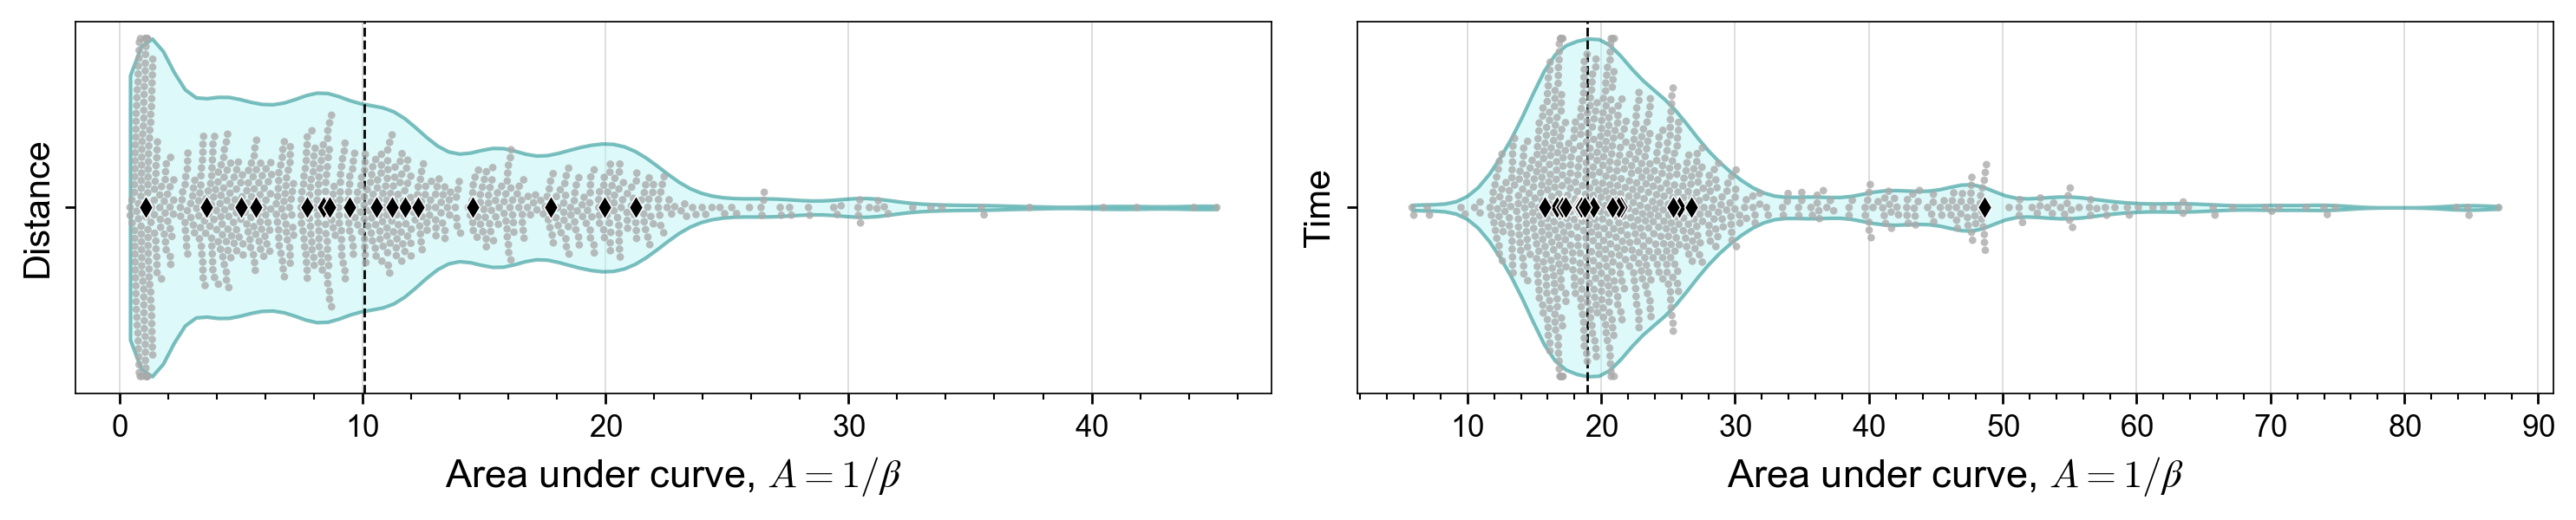

In [15]:
def fig_violinplot(betas=betas, levels=levels, dpi=150):
    _, axes = plt.subplots(1, 2, figsize=(12, 2.5), dpi=dpi)
    for i, (target, win) in enumerate([('Distance', 2.5), ('Time', 2.5)]):
        df = betas.query(f'Target=="{target}"')
        df = df.merge(combs, on='Comb')
        ovrl = df.query('Comb==0').iloc[0].Area
        ax = pplot(axes[i])
        sns.violinplot(df, x='Area', ax=ax, color='#B2FFFF',
                       edgecolor='teal', cut=0, linewidth=1.2,
                       alpha=0.5, inner=None, bw_adjust=0.5)
        sns.swarmplot(df, x='Area', ax=ax, size=2.5, alpha=0.8,
                      color='#aaa', edgecolor='none')
        lvl = df.merge(levels, on='Comb')
        ax.axvline(ovrl, ls='--', color='k', lw=0.8)
        sns.scatterplot(lvl, x='Area', y=0, marker='d',
                        s=30, color='k', ax=ax, zorder=1234)
        ax.set_xlabel('Area under curve, $A=1/β$')
        ax.set_yticklabels([target], va='center', rotation=90, fontsize=12)
        lvl.sort_values('Area').iloc[[0, -1]].disp(None)
    plt.tight_layout()
    return df

x = fig_violinplot(dpi=250); x # t=0:05

In [16]:
a = x.merge(levels['Comb']).Area
arng = sum([list(np.arange(np.floor(x - 2.5), np.ceil(x + 2.5))) for x in a], [])
arng = Series(arng, name='A').drop_duplicates().sort_values().reset_index(drop=1)
arng

0     13.0
1     14.0
2     15.0
3     16.0
4     17.0
5     18.0
6     19.0
7     20.0
8     21.0
9     22.0
10    23.0
11    24.0
12    25.0
13    26.0
14    27.0
15    28.0
16    29.0
17    46.0
18    47.0
19    48.0
20    49.0
21    50.0
22    51.0
Name: A, dtype: float64

In [17]:
diff = arng[(arng.diff() != 1).fillna(False)]
diff

0     13.0
17    46.0
Name: A, dtype: float64

9,090 rows x 6 cols; Memory: 1.9 MiB


Target     Comb       Area       Beta    Factor     Level
   <object>  <int64>  <float64>  <float64>  <object>  <object>
0  Distance        0  10.073197   0.099273      Mode   Overall

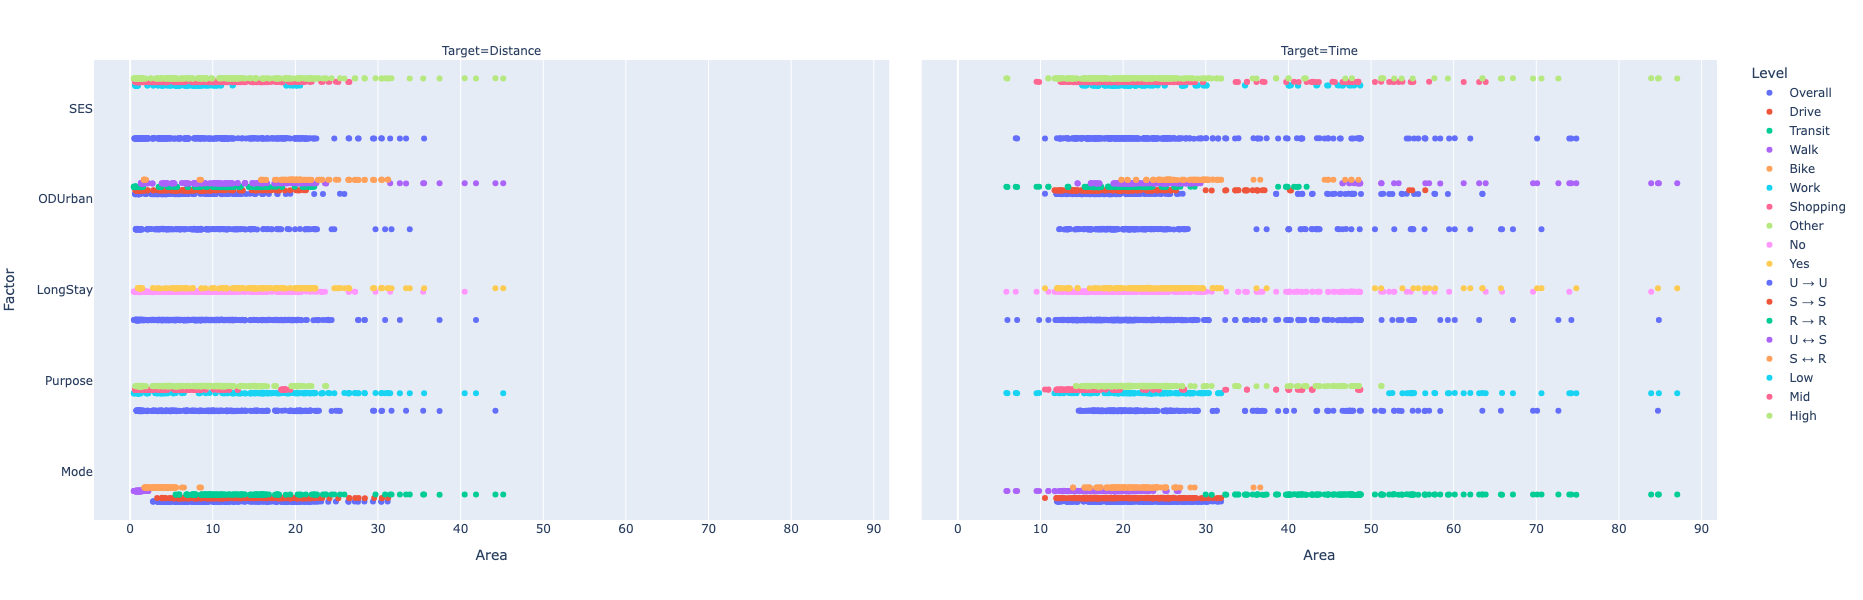

In [18]:
df = betas.merge(combs, on='Comb').melt(['Target', 'Comb', 'Area', 'Beta'], var_name='Factor', value_name='Level').disp()
px.strip(df, x='Area', y='Factor', color='Level', facet_col='Target', height=600)

1,818 rows x 9 cols; Memory: 0.2 MiB


Comb    Target       Beta       Area        Mode     Purpose    LongStay  \
  <int64>  <object>  <float64>  <float64>  <category>  <category>  <category>   

     ODUrban         SES  
  <category>  <category>

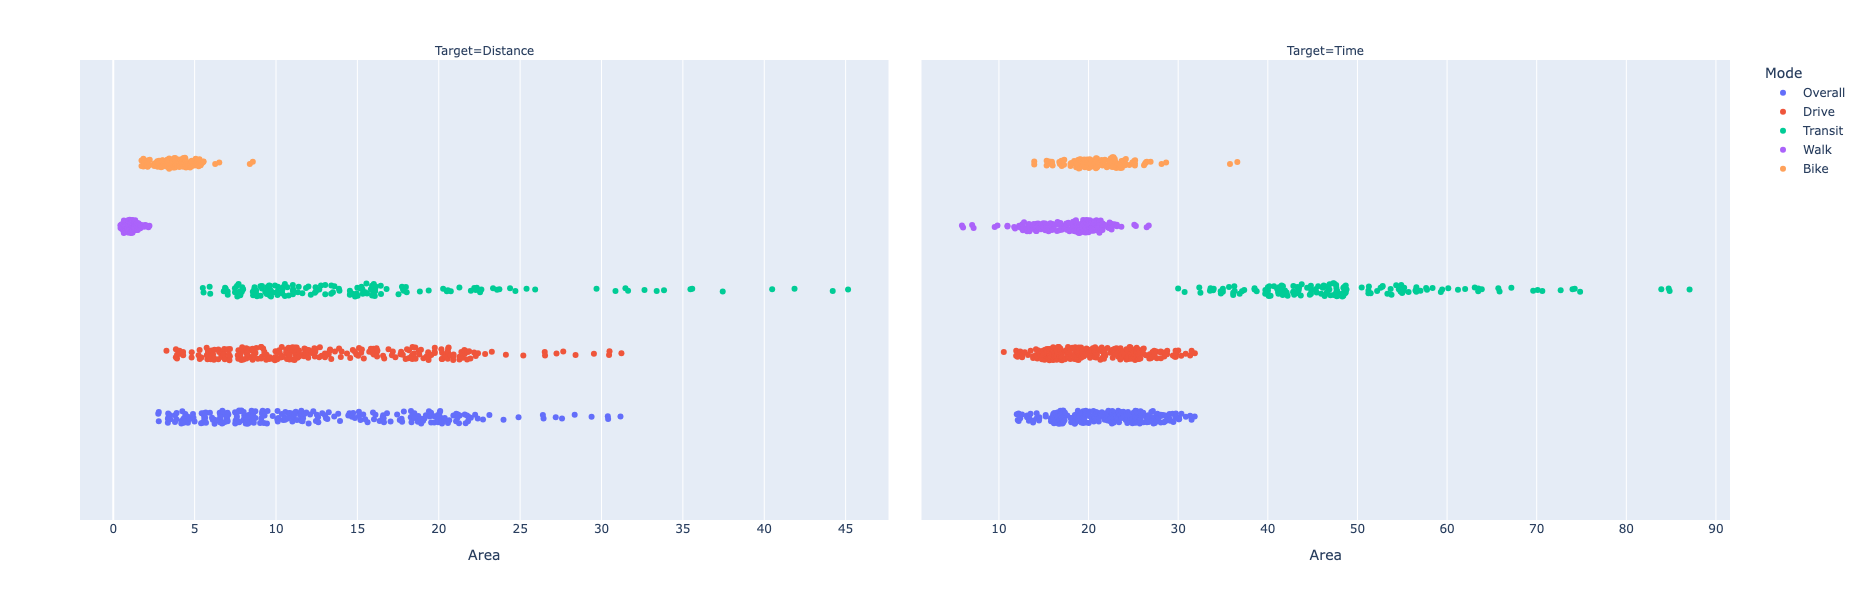

In [19]:
df = betas.merge(combs, on='Comb').disp(0)
fig = px.strip(df, x='Area', facet_col='Target', color='Mode', height=600,
         hover_data=['Mode', 'Purpose', 'LongStay', 'ODUrban', 'SES'])
fig.for_each_xaxis(lambda x: x.update(matches=None))

/tmp/ipykernel_135633/982310393.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_135633/982310393.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



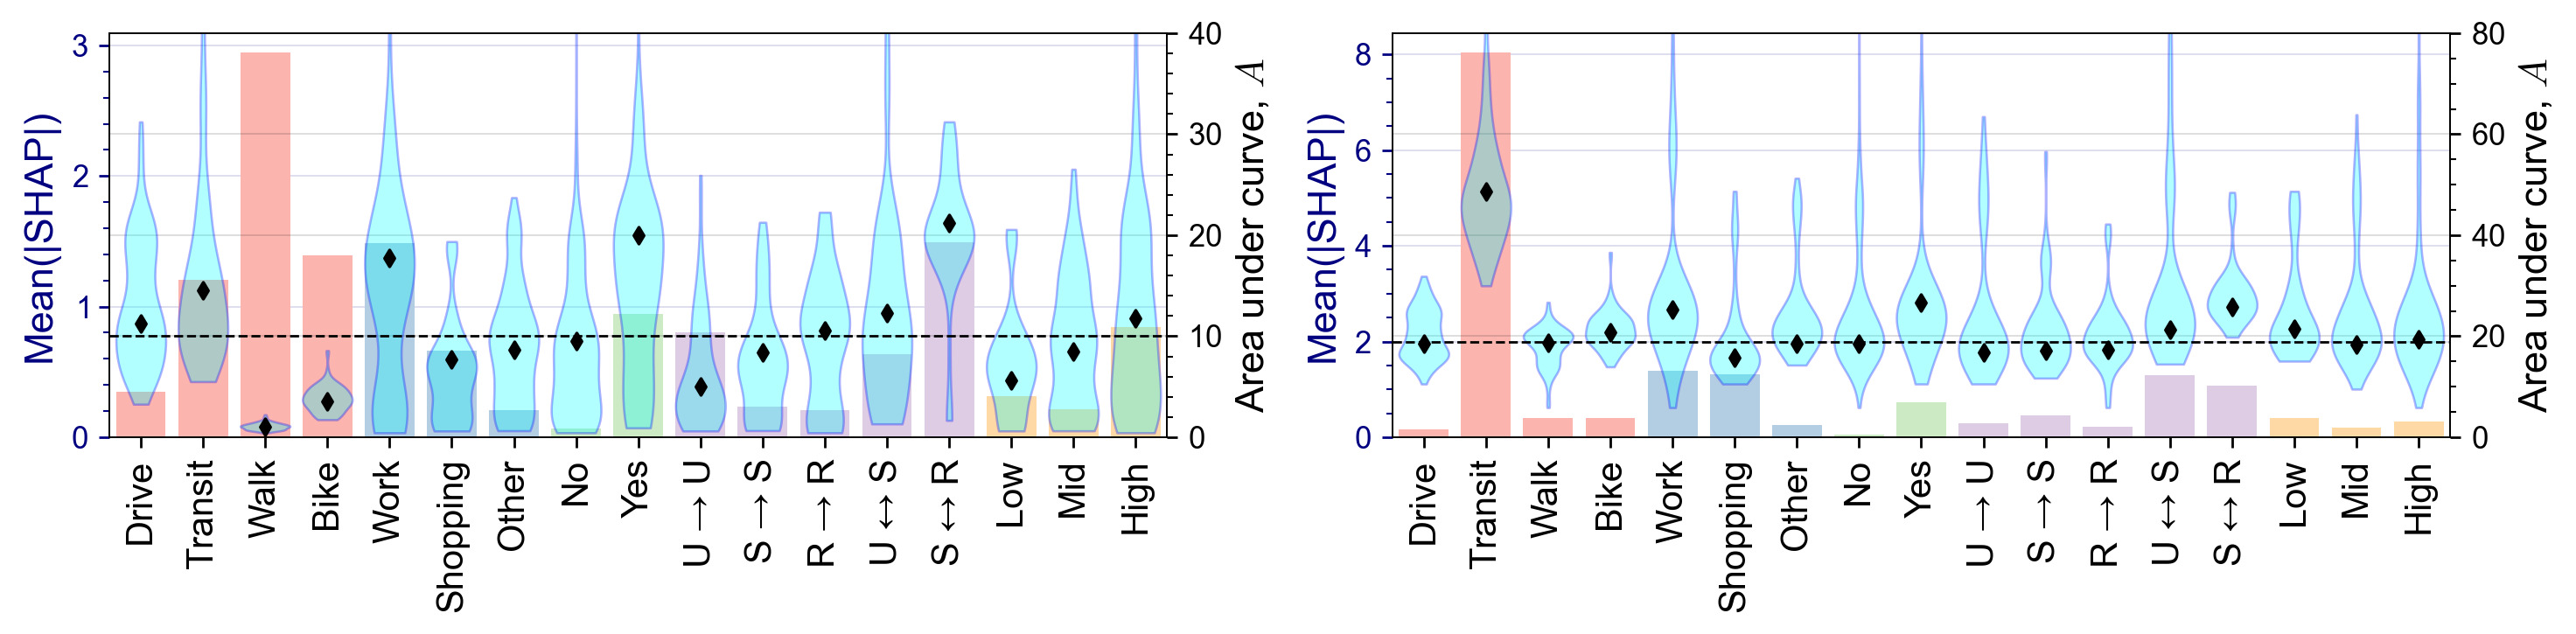

In [20]:
def fit_comb_curves(combs=combs, shaps=shaps, betas=betas, dpi=150, cmap='Pastel1'):
    factors = Series([x.split('_')[0] for x in 
                      shaps.iloc[:, 1:].columns]).drop_duplicates()
    colors = D(zip(factors, sns.color_palette(cmap, len(factors)).as_hex()))
    _, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=dpi)
    for i, (target, amax, max_shap) in enumerate([
            ('Distance', 40, 5), ('Time', 80, 5)]):
        ## SHAP contribution
        df = shaps.query(f'Target=="{target}"').drop(columns='Target')
        df = np.abs(df).mean().rename('contrib').reset_index()
        df['factor'], df['level'] = [ordered_factor(x) for x in 
                                     zip(*df.pop('index').str.split('_'))]
        df = df[df.level != 'Overall'].reset_index(drop=1)
        df['color'] = df.factor.map(colors)
        ax = pplot(axes[i], xminor=0, yminor=0, gridcolor='navy', xlim=(-0.5, len(df) - 0.5))
        ax.bar(df.level, df.contrib, color=df.color, alpha=1)
        ax.set_xticklabels(df.level, rotation=90, fontsize=12)
        ax.tick_params(axis='y', which='both', colors='navy')
        ax.grid(False, axis='x')
        ax.set_ylabel('Mean(|SHAP|)', color='navy')
        ## Parameters
        twin = pplot(ax.twinx(), ylab='Area under curve, $A$', yminor=0, ylim=(0, amax))
        levels = df[['factor', 'level']].rename_axis('idx').reset_index()
        df = betas.query(f'Target=="{target}"').merge(combs, on='Comb')
        vals = sum([[d.Area for level, d in df.groupby(col)
                     if level != 'Overall'] for col in factors], [])
        x = twin.violinplot(vals, positions=range(len(vals)),
                            widths=0.8, showextrema=False)
        for line in x['bodies']:
            line.set_facecolor('#0ffa')
            line.set_edgecolor('b')
            line.set_linewidth(0.75)
        for col in factors:
            others = [f'{x}=="Overall"' for x in set(factors) - {col}]
            for _, r in df.query(' & '.join(others)).iterrows():
                if r[col] == 'Overall' or r.Area > amax:
                    continue
                x = levels.query(f'factor=="{col}" & level=="{r[col]}"').iloc[0]
                twin.scatter(x.idx, r.Area, marker='d', c='k', s=15)
        overall = df.query(' & '.join([f'{x}=="Overall"' for x in factors]))
        twin.axhline(overall.iloc[0].Area, ls='--', lw=0.8, color='k')
    plt.tight_layout()

x = fit_comb_curves(dpi=250); x